# GTHA housing market database
# OSEMN methodology Step 4: Model
# Classify land use from new features in Teranet (3 classes)
# Top 11 selected features
# Nearest Neighbours

Top 11 selected features and with missing past/future xy sales filled with mean future/past xy sales.

---

This notebook describes _Step 4: Model_ of OSEMN methodology performed on the Teranet dataset.

## Import dependencies

In [2]:
random_state = 1

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, minmax_scale, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from time import time

sns.set()

In [4]:
import sys

sys.path.append('../../../../src')

from io_utils import df_from_csv
from plot_utils import plot_hist
from model_utils import get_fit_times, fit_model, plot_learning_curve, plot_validation_curve

## Load Teranet data

In [5]:
data_path = '../../../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '4_Teranet_lu_predict_3c.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '4_Teranet_lu_predict_4c.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [6]:
teranet_df = df_from_csv(teranet_path + '4_Teranet_lu_predict_3c.csv', parse_dates=['registration_date'])

----- DataFrame loaded
in 92.84 seconds
with 5,188,513 rows
and 79 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_change

## Load Census data

In [7]:
census_path = data_path + 'census/'
os.listdir(census_path)

['da_census_income.csv',
 'Census data availability.xlsx',
 'da_census.xls',
 'da_census_select_tidy.csv',
 'da_census_income_shapefile',
 'da_census_select.csv']

In [8]:
census_df = df_from_csv(census_path + 'da_census_select_tidy.csv')

----- DataFrame loaded
in 0.17 seconds
with 36,728 rows
and 32 columns
-- Column names:
 Index(['DAUID', 'year', 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
       'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
       'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
       'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object')


## Load TTS data

In [9]:
tts_path = data_path + 'tts/'
os.listdir(tts_path)

['tts_num_jobs_tidy.csv',
 'TAZ_2001shp.zip',
 'TAZ_2001shp',
 'taz_tts_tidy.csv',
 'taz_info.csv',
 'TTS_variables.xlsx',
 'taz_tts.xlsx',
 'Num_of_Jobs.xlsx']

In [10]:
tts_df = df_from_csv(tts_path + 'taz_tts_tidy.csv')

----- DataFrame loaded
in 0.01 seconds
with 12,012 rows
and 8 columns
-- Column names:
 Index(['TAZ_O', 'year', 'Pop', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars'], dtype='object')


## Join Census data to Teranet data

In [11]:
t = time()
df = pd.merge(teranet_df, census_df, how='left',
              left_on=['dauid', 'census2001_year'], right_on=['DAUID', 'year'])
df = df.drop(['DAUID', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- Census variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- Census variables were joined to the DataFrame
in 50.48 seconds (0.84 minutes)
with 5,188,513 rows
and 109 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Emp', 'Unemp', 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home',
       'No_fix_wkpl', 'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object', length=109)


## Join TTS data to Teranet data

In [12]:
t = time()
df = pd.merge(df, tts_df, how='left',
              left_on=['taz_o', 'tts_year'], right_on=['TAZ_O', 'year'])
df = df.drop(['taz_o', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- TTS variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- TTS variables were joined to the DataFrame
in 54.35 seconds (0.91 minutes)
with 5,188,513 rows
and 115 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=115)


## Take a train-test subset of Teranet records

In [13]:
year_train_test = 2012
year_val1 = 2011
year_val2 = 2013

s = df.query('year == @year_train_test')
s_val1 = df.query('year == @year_val1')
s_val2 = df.query('year == @year_val2')

print("{0:,} Teranet records in the train-test subset (records from {1})."
      .format(len(s), year_train_test))
print("{0:,} Teranet records in the validation subset #1 (records from {1}).".format(len(s_val1), year_val1))
print("{0:,} Teranet records in the validation subset #2 (records from {1}).".format(len(s_val2), year_val2))

205,341 Teranet records in the train-test subset (records from 2012).
219,130 Teranet records in the validation subset #1 (records from 2011).
207,686 Teranet records in the validation subset #2 (records from 2013).


## Select features

In [14]:
s.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=115)

In [15]:
top11f = ['xy_total_sales', 'xy_prev_sales', 'xy_first_sale',
          'xy_years_since_last_sale', 'xy_years_to_next_sale', 'med_price_xy',
          'Avg_HHsize', 'Avg_rent', 'PopDens', 'DwelDens', 'Apt_5plus',
          'lucr']
s = s[top11f]
s_val1 = s_val1[top11f]
s_val2 = s_val2[top11f]
s.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205341 entries, 0 to 205340
Data columns (total 12 columns):
xy_total_sales              205341 non-null int64
xy_prev_sales               205341 non-null int64
xy_first_sale               205341 non-null bool
xy_years_since_last_sale    176503 non-null float64
xy_years_to_next_sale       137302 non-null float64
med_price_xy                205341 non-null float64
Avg_HHsize                  204722 non-null float64
Avg_rent                    204736 non-null float64
PopDens                     205341 non-null float64
DwelDens                    205341 non-null float64
Apt_5plus                   204722 non-null float64
lucr                        205341 non-null object
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 19.0+ MB


## Fill missing values

In [16]:
col1 = 'xy_years_to_next_sale'
col2 = 'xy_years_since_last_sale'
mask1 = s[col1].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col1, col2, s.loc[mask1, col2].mean(), s.loc[mask1, col2].median()))
mask1 = s[col2].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col2, col1, s.loc[mask1, col1].mean(), s.loc[mask1, col1].median()))

For records with missing 'xy_years_to_next_sale', values of 'xy_years_since_last_sale' are: mean=7.59, median=5.89
For records with missing 'xy_years_since_last_sale', values of 'xy_years_to_next_sale' are: mean=2.07, median=1.72


In [17]:
# missing year to next sale is replaced with median year since last sale and vice versa
mask1 = s[col1].isnull()
s.loc[mask1, col1] = s.loc[mask1, col2].median()
mask1 = s_val1[col1].isnull()
s_val1.loc[mask1, col1] = s_val1.loc[mask1, col2].median()
mask1 = s_val2[col1].isnull()
s_val2.loc[mask1, col1] = s_val2.loc[mask1, col2].median()

mask1 = s[col2].isnull()
s.loc[mask1, col2] = s.loc[mask1, col1].median()
mask1 = s_val1[col2].isnull()
s_val1.loc[mask1, col2] = s_val1.loc[mask1, col1].median()
mask1 = s_val2[col2].isnull()
s_val2.loc[mask1, col2] = s_val2.loc[mask1, col1].median()

s.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205341 entries, 0 to 205340
Data columns (total 12 columns):
xy_total_sales              205341 non-null int64
xy_prev_sales               205341 non-null int64
xy_first_sale               205341 non-null bool
xy_years_since_last_sale    205341 non-null float64
xy_years_to_next_sale       205341 non-null float64
med_price_xy                205341 non-null float64
Avg_HHsize                  204722 non-null float64
Avg_rent                    204736 non-null float64
PopDens                     205341 non-null float64
DwelDens                    205341 non-null float64
Apt_5plus                   204722 non-null float64
lucr                        205341 non-null object
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 19.0+ MB


In [18]:
s = s.dropna()
s_val1 = s_val1.dropna()
s_val2 = s_val2.dropna()
print("{0:,} rows in train-test subset, {1:,} rows in validation subset #1, {2:,} rows in validation subset #2"
      .format(len(s), len(s_val1), len(s_val2)))

204,722 rows in train-test subset, 217,955 rows in validation subset #1, 207,281 rows in validation subset #2


In [19]:
target_cols = 4
feat_cols = s.columns[:-target_cols]
feat_cols

Index(['xy_total_sales', 'xy_prev_sales', 'xy_first_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale', 'med_price_xy',
       'Avg_HHsize', 'Avg_rent'],
      dtype='object')

In [20]:
feat_set_name = 'top11f_3c'

## Encode target

In [21]:
le = LabelEncoder()

s['lucr_e'] = le.fit_transform(s['lucr'])
s_val1['lucr_e'] = le.transform(s_val1['lucr'])
s_val2['lucr_e'] = le.transform(s_val2['lucr'])

print(s['lucr'].value_counts().sort_index())
print(s['lucr_e'].value_counts().sort_index())
print(s_val1['lucr'].value_counts().sort_index())
print(s_val1['lucr_e'].value_counts().sort_index())
print(s_val2['lucr'].value_counts().sort_index())
print(s_val2['lucr_e'].value_counts().sort_index())

s = s.drop(['lucr'], axis=1)
s_val1 = s_val1.drop(['lucr'], axis=1)
s_val2 = s_val2.drop(['lucr'], axis=1)
print("Land use encoded!")

condo    55527
house    72935
other    76260
Name: lucr, dtype: int64
0    55527
1    72935
2    76260
Name: lucr_e, dtype: int64
condo    62648
house    74123
other    81184
Name: lucr, dtype: int64
0    62648
1    74123
2    81184
Name: lucr_e, dtype: int64
condo    48276
house    69660
other    89345
Name: lucr, dtype: int64
0    48276
1    69660
2    89345
Name: lucr_e, dtype: int64
Land use encoded!


## Prepare features

### Select features and target

In [22]:
X = s[feat_cols].values
X_val1 = s_val1[feat_cols].values
X_val2 = s_val2[feat_cols].values
y = s['lucr_e'].values
y_val1 = s_val1['lucr_e'].values
y_val2 = s_val2['lucr_e'].values
print("Features and target selected.")

Features and target selected.


### Perform the train-test split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)
print("Performed train-test split.")
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
print('Labels counts in y_val1:', np.bincount(y_val1))
print('Labels counts in y_val2:', np.bincount(y_val2))

Performed train-test split.
Labels counts in y: [55527 72935 76260]
Labels counts in y_train: [38869 51054 53382]
Labels counts in y_test: [16658 21881 22878]
Labels counts in y_val1: [62648 74123 81184]
Labels counts in y_val2: [48276 69660 89345]


### Standardize features

In [24]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_val1_std = sc.transform(X_val1)
X_val2_std = sc.transform(X_val2)
print("Input features were standardized.")

Input features were standardized.


### Normalize features (Min-Max scaling)

In [25]:
sc = MinMaxScaler()
sc.fit(X_train)
X_train_norm = sc.transform(X_train)
X_test_norm = sc.transform(X_test)
X_val1_norm = sc.transform(X_val1)
X_val2_norm = sc.transform(X_val2)
print("Input features were normalized.")

Input features were normalized.


### Max-Abs scaling

In [26]:
sc = MaxAbsScaler()
sc.fit(X_train)
X_train_ma = sc.transform(X_train)
X_test_ma = sc.transform(X_test)
X_val1_ma = sc.transform(X_val1)
X_val2_ma = sc.transform(X_val2)
print("Max-Abs scaling was applied to the features.")

Max-Abs scaling was applied to the features.


### Robust scaling

In [27]:
sc = RobustScaler(quantile_range=(25, 75))
sc.fit(X_train)
X_train_r = sc.transform(X_train)
X_test_r = sc.transform(X_test)
X_val1_r = sc.transform(X_val1)
X_val2_r = sc.transform(X_val2)
print("Robust scaling was applied to the features.")

Robust scaling was applied to the features.


### Apply the power (Yeo-Johnson) transormation to the features

In [28]:
sc = PowerTransformer(method='yeo-johnson')
sc.fit(X_train)
X_train_yj = sc.transform(X_train)
X_test_yj = sc.transform(X_test)
X_val1_yj = sc.transform(X_val1)
X_val2_yj = sc.transform(X_val2)
print("Power (Yeo-Johnson) transformation was applied to the features.")

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Power (Yeo-Johnson) transformation was applied to the features.


### Apply the power (Box-Cox) transormation to the features

In [28]:
sc = PowerTransformer(method='box-cox')
sc.fit(X_train)
X_train_bc = sc.transform(X_train)
X_test_bc = sc.transform(X_test)
X_val1_bc = sc.transform(X_val1)
X_val2_bc = sc.transform(X_val2)
print("Power (Box-Cox) transformation was applied to the features.")

ValueError: The Box-Cox transformation can only be applied to strictly positive data

### Apply the quantile transformation (gaussian pdf) to the features

In [29]:
sc = QuantileTransformer(output_distribution='normal')
sc.fit(X_train)
X_train_qn = sc.transform(X_train)
X_test_qn = sc.transform(X_test)
X_val1_qn = sc.transform(X_val1)
X_val2_qn = sc.transform(X_val2)
print("Quantile transformation (gaussian pdf) was applied to the features.")

Quantile transformation (gaussian pdf) was applied to the features.


### Apply the quantile transformation (uniform pdf) to the features

In [30]:
sc = QuantileTransformer(output_distribution='uniform')
sc.fit(X_train)
X_train_qu = sc.transform(X_train)
X_test_qu = sc.transform(X_test)
X_val1_qu = sc.transform(X_val1)
X_val2_qu = sc.transform(X_val2)
print("Quantile transformation (uniform pdf) was applied to the features.")

Quantile transformation (uniform pdf) was applied to the features.


### Apply sample-wise L2 normalizing to the features

In [31]:
sc = Normalizer()
sc.fit(X_train)
X_train_l2 = sc.transform(X_train)
X_test_l2 = sc.transform(X_test)
X_val1_l2 = sc.transform(X_val1)
X_val2_l2 = sc.transform(X_val2)
print("Sample-wise L2 normalizing was applied to the features.")

Sample-wise L2 normalizing was applied to the features.


### Construct feature dictionary

In [32]:
feat_dict = {
    'raw': {'train': X_train, 'test': X_test, 'val1': X_val1, 'val2': X_val2},
    'std': {'train': X_train_std, 'test': X_test_std, 'val1': X_val1_std, 'val2': X_val2_std},
    'norm': {'train': X_train_norm, 'test': X_test_norm, 'val1': X_val1_norm, 'val2': X_val2_norm},
    'max-abs': {'train': X_train_ma, 'test': X_test_ma, 'val1': X_val1_ma, 'val2': X_val2_ma},
    'robust': {'train': X_train_r, 'test': X_test_r, 'val1': X_val1_r, 'val2': X_val2_r},
    'power-yj': {'train': X_train_yj, 'test': X_test_yj, 'val1': X_val1_yj, 'val2': X_val2_yj},
    'quant-norm': {'train': X_train_qn, 'test': X_test_qn, 'val1': X_val1_qn, 'val2': X_val2_qn},
    'quant-uni': {'train': X_train_qu, 'test': X_test_qu, 'val1': X_val1_qu, 'val2': X_val2_qu},    
    'swl2': {'train': X_train_l2, 'test': X_test_l2, 'val1': X_val1_l2, 'val2': X_val2_l2}
}

In [33]:
target_dict = {'train': y_train, 'test': y_test, 'val1': y_val1, 'val2': y_val2}

## Fit times

In [74]:
times_scores_df = pd.DataFrame()

### K-nearest neighbors (Manhattan distance)

In [75]:
n_jobs = 12
k = 5
p = 1
model_name = "K-nearest neighbors (p={0})".format(p)
model_code = 'knn_k{0}_p{1}'.format(k, p)
model = KNeighborsClassifier(metric='minkowski', n_neighbors=k, p=p, n_jobs=n_jobs)
model_times_scores_df = get_fit_times(model, feat_dict, target_dict, model_name, model_code, n_jobs)
times_scores_df = times_scores_df.append(model_times_scores_df)

K-nearest neighbors (p=1) fit, took 85.82 seconds (1.43 minutes) in total


### K-nearest neighbors (Euclidean distance)

In [76]:
n_jobs = 12
k = 5
p = 2
model_name = "K-nearest neighbors (p={0})".format(p)
model_code = 'knn_k{0}_p{1}'.format(k, p)
model = KNeighborsClassifier(metric='minkowski', n_neighbors=k, p=p, n_jobs=n_jobs)
model_times_scores_df = get_fit_times(model, feat_dict, target_dict, model_name, model_code, n_jobs)
times_scores_df = times_scores_df.append(model_times_scores_df)

K-nearest neighbors (p=2) fit, took 80.05 seconds (1.33 minutes) in total


## Compare perfomance of models

In [84]:
times_scores_df = times_scores_df.reset_index().rename(columns={'index': 'model'})

In [85]:
times_scores_df = times_scores_df.set_index('result')

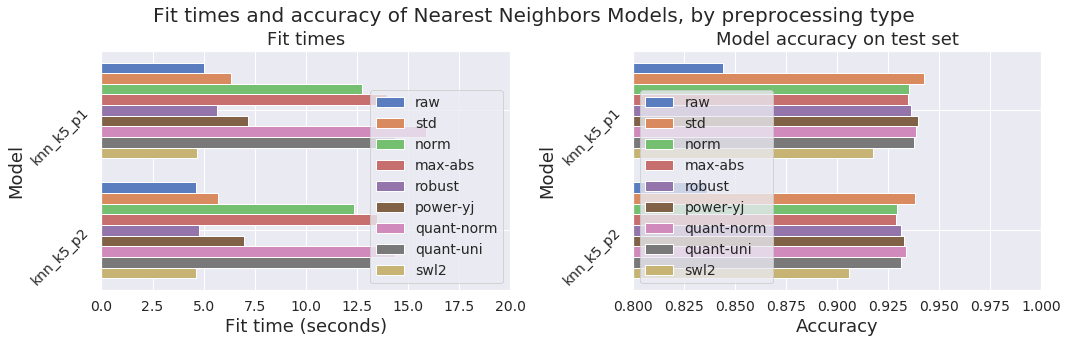

In [86]:
fit_times_df = pd.melt(times_scores_df.loc['fit_time'], id_vars=['model'], var_name='preprocessing', value_name='fit_time')
acc_df = pd.melt(times_scores_df.loc['acc'], id_vars=['model'], var_name='preprocessing', value_name='acc')

f, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.barplot(y="model", x="fit_time", hue="preprocessing", data=fit_times_df, palette="muted", ax=axes[0])
axes[0].set_ylabel("Model", fontsize=18)
axes[0].set_xlabel("Fit time (seconds)", fontsize=18)
axes[0].set_title("Fit times", fontsize=18)
axes[0].set_xlim(0.0, 20.0)
axes[0].grid(axis='y')
axes[0].legend(loc='lower right', fontsize=14)
axes[0].xaxis.set_tick_params(labelsize=14)
axes[0].yaxis.set_tick_params(labelrotation=45, labelsize=14)

sns.barplot(y="model", x="acc", hue="preprocessing", data=acc_df, palette="muted", ax=axes[1])
axes[1].set_ylabel("Model", fontsize=18)
axes[1].set_xlabel("Accuracy", fontsize=18)
axes[1].set_title("Model accuracy on test set", fontsize=18)
axes[1].set_xlim(0.8, 1.0)
axes[1].grid(axis='y')
axes[1].legend(loc='lower left', fontsize=14)
axes[1].xaxis.set_tick_params(labelsize=14)
axes[1].yaxis.set_tick_params(labelrotation=45, labelsize=14)

plt.suptitle('Fit times and accuracy of Nearest Neighbors Models, by preprocessing type', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('../../results/plots/neighbors_fit_times_' + feat_set_name + '.png'
            .format(model_name), dpi=300, bbox_inches='tight')

## Validation curves

### K-nearest neighbors (Manhattan distance)

Validation curve for K-nearest neighbors (p=1, standardized) plotted, took 894.59 seconds (14.91 minutes)


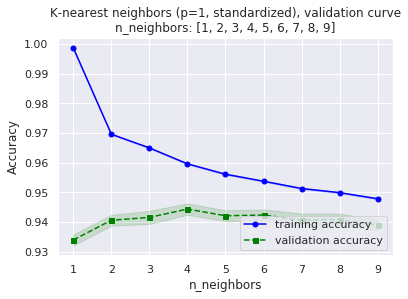

In [71]:
n_jobs = 12
p = 1
model_name = "K-nearest neighbors (p={0}, standardized)".format(p)
param_name = 'n_neighbors'
param_range = list(range(1, 10))
model = KNeighborsClassifier(metric='minkowski', p=p, n_jobs=n_jobs)
plot_validation_curve(model, model_name, X_train_std, y_train, param_name, param_range, n_jobs=n_jobs)

Validation curve for K-nearest neighbors (p=2, standardized) plotted, took 880.37 seconds (14.67 minutes)


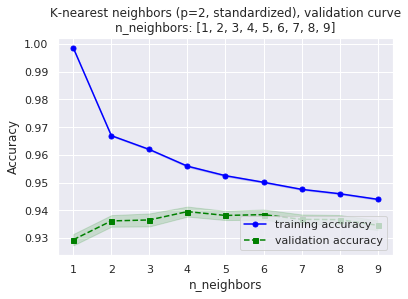

In [72]:
n_jobs = 12
p = 2
model_name = "K-nearest neighbors (p={0}, standardized)".format(p)
param_name = 'n_neighbors'
param_range = list(range(1, 10))
model = KNeighborsClassifier(metric='minkowski', p=p, n_jobs=n_jobs)
plot_validation_curve(model, model_name, X_train_std, y_train, param_name, param_range, n_jobs=n_jobs)

## Hyperparameter tuning via grid search

In [83]:
n_jobs = 12

param_grid = [{'p': [1, 2],
               'n_neighbors': list(range(1, 10, 1))}]

t = time()

model = KNeighborsClassifier(metric='minkowski', n_jobs=n_jobs)
gs = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=1)

gs = gs.fit(X_train_std, y_train)

elapsed = time() - t

print("Best score: {0:.2f}".format(gs.best_score_))
print("Best parameters:\n", gs.best_params_)
print("took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))

Best score: 0.94
Best parameters:
 {'n_neighbors': 4, 'p': 1}
took 298.10 seconds (4.97 minutes)


## Learning curves

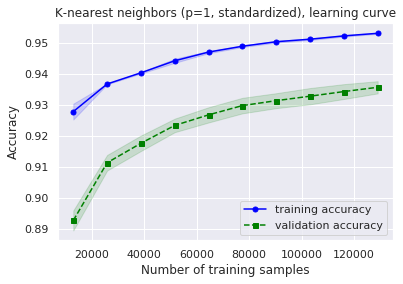

In [87]:
n_jobs = 12
p = 1
k = 4
model_name = "K-nearest neighbors (p={0}, standardized)".format(p)
param_name = 'n_neighbors'
param_range = list(range(1, 10))
model = KNeighborsClassifier(metric='minkowski', p=p, n_jobs=n_jobs, n_neighbors=k)
plot_learning_curve(model, model_name, X_train_std, y_train, n_jobs=1)

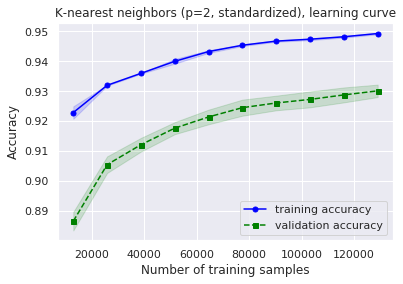

In [88]:
n_jobs = 12
p = 2
model_name = "K-nearest neighbors (p={0}, standardized)".format(p)
param_name = 'n_neighbors'
param_range = list(range(1, 10))
model = KNeighborsClassifier(metric='minkowski', p=p, n_jobs=n_jobs, n_neighbors=k)
plot_learning_curve(model, model_name, X_train_std, y_train, n_jobs=1)